<a href="https://colab.research.google.com/github/lucash-h/Manifold-Guided-GAN/blob/main/MyGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

GAN steps
import library
load and process mnist data
set up data
build generator
build discriminator
get loss functions
train
show results

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob
import time
from tensorflow.keras import layers
import time
from tensorflow.keras.layers import Dense, Conv2D, Dropout, LeakyReLU, Flatten, Reshape, BatchNormalization, Conv2DTranspose, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tqdm import tqdm

Tips
https://github.com/soumith/ganhacks




In [3]:
(real_images, real_labels), (_,_) = tf.keras.datasets.mnist.load_data()
#real_images = ((real_images / 255.0) * 2) - 1
real_images = real_images / 255.0
batch_size = 32
real_images = tf.reshape(real_images,(-1,batch_size,28,28,1))
print(type(real_images))

11490434/11490434 [==============================] - 0s 0us/step
<class 'tensorflow.python.framework.ops.EagerTensor'>


Check OG paper on GANS apparently leaky relu preceded by batch normalization

In [4]:
def build_generator(latent_dimension):
  xin = Input((latent_dimension))
  xout = Dense(7*7*128, input_dim = latent_dimension)(xin) #map input noise to higher dimension
  xout = Reshape((7,7,128))(xout) #reshape so suitable for convolution
  xout = BatchNormalization()(xout) #normalizes
  xout = LeakyReLU(alpha=0.2)(xout) #non linearity
  xout = Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same')(xout) #generate higher res
  xout = BatchNormalization()(xout)
  xout = LeakyReLU(alpha=0.2)(xout)
  xout = Conv2DTranspose(1, (4, 4), strides=(2, 2), padding='same', activation='sigmoid')(xout) #tanh provides higher res -1 -> 1 rather than 0 -> 1 and vals are centered @ 0 for other layers
  return Model(xin,xout)

In [5]:
def build_discriminator():
    xin = Input((28,28,1))
    xout = Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(28, 28, 1))(xin)
    xout = LeakyReLU(alpha=0.2)(xout)
    xout = Dropout(0.4)(xout)
    xout = Conv2D(128, (3, 3), strides=(2, 2), padding='same')(xout)
    xout = LeakyReLU(alpha=0.2)(xout)
    xout = Dropout(0.4)(xout)
    xout = Flatten()(xout)
    xout = Dense(1, activation='sigmoid')(xout) #sets vals 0-1 --> fake - real

    return Model(xin,xout)

In [6]:
latent_dimension = 100
noise_dimension = 100

generator = build_generator(latent_dimension)
discriminator = build_discriminator()

In [7]:
generator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense (Dense)               (None, 6272)              633472    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 14, 14, 128)       262272    
 anspose)                                                    

In [8]:
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         73856     
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0   

In [9]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
disc_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

In [10]:
epochs = 20

In [15]:
@tf.function
def train_step(images):
# Training loop
  noise = tf.random.normal([batch_size, noise_dimension])

  with tf.GradientTape() as gen_tape:
    generated_images = generator(noise)

    fake_output = discriminator(generated_images)
    generator_loss = bce(tf.ones(batch_size),fake_output)
    print("Generator loss: ")
    print(generator_loss)


  gradients_of_generator = gen_tape.gradient(generator_loss, generator.trainable_variables)
  gen_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

  with tf.GradientTape() as disc_tape:
    real_output = discriminator(images)
    fake_output = discriminator(generated_images)
    discriminator_fake_loss = bce(tf.zeros(batch_size),fake_output)
    discriminator_real_loss = bce(tf.ones(batch_size),real_output)

    total_discriminator_loss = discriminator_fake_loss + discriminator_real_loss
    print("Discriminator loss: ")
    print(total_discriminator_loss)

  gradients_of_discriminator = disc_tape.gradient(total_discriminator_loss, discriminator.trainable_variables)
  disc_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))




for epoch in range(epochs):
  for batch in tqdm(real_images):
    train_step(batch)

  0%|          | 0/1875 [00:00<?, ?it/s]

Generator loss: 
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Discriminator loss: 
Tensor("add:0", shape=(), dtype=float32)
Generator loss: 
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Discriminator loss: 
Tensor("add:0", shape=(), dtype=float32)


100%|██████████| 1875/1875 [00:08<00:00, 216.95it/s]


In [11]:
n_generated_samples = 64
generated = generator(tf.random.normal((n_generated_samples,100)))

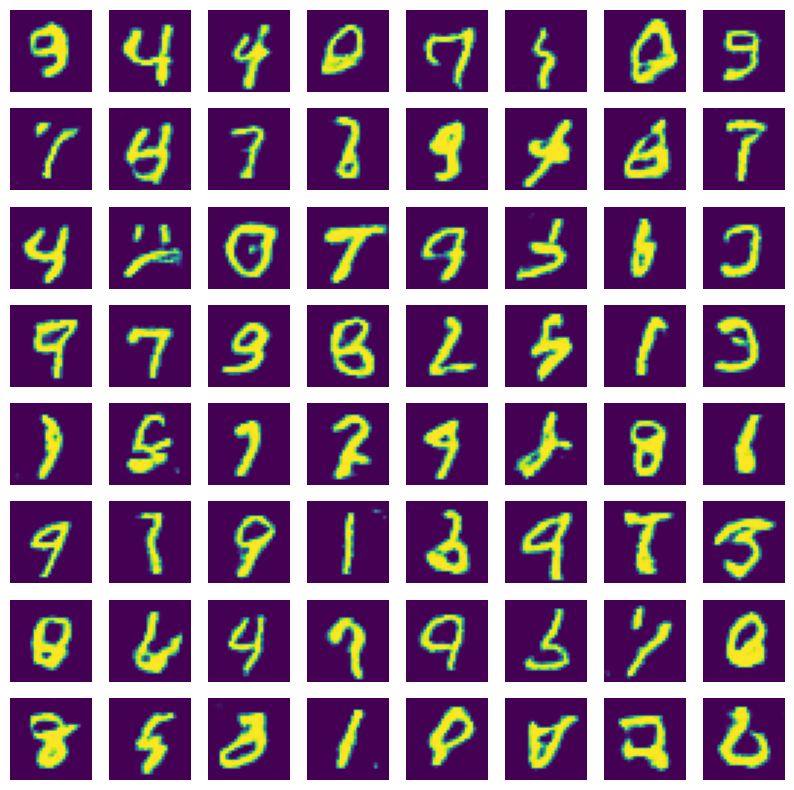

In [12]:
 # visualize generated images

samples = 64
_edge_length = int(np.sqrt(samples))
fig,ax = plt.subplots(nrows = _edge_length, ncols = _edge_length,figsize=(10,10))
for i in range(_edge_length**2):
  ax[i//_edge_length][i%_edge_length].imshow(generated[i, :, :, 0])
  ax[i//8][i%8].axis('off')


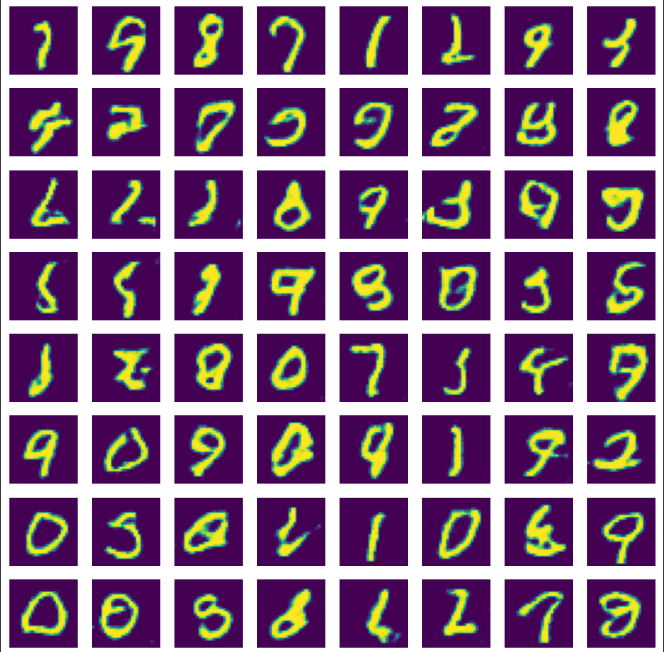

More epochs <br>
Accuracy <br>
plot losses & curves

> Indented block

